## Milestone 3 - Katie Perkins

## Introduction

Access to safe drinking-water is essential to health, is a basic human right, and effective policies are needed for public health. This is an important health and development issue at a national, regional and local level. In some regions, it has been shown that investments in water supply and sanitation can yield a net economic benefit, since the reductions in adverse health effects and health care costs outweigh the costs of undertaking the interventions.

Contaminated water and poor sanitation are linked to a number of diseases, such as, cholera, diarrhoea, dysentery, hepatitis A, typhoid, and polio. Absent, inadequate, or inappropriately managed water and sanitation services expose individuals to preventable health risks. This is particularly the case in health care facilities where both patients and staff are placed at additional risk of infection and disease when water, sanitation, and hygiene services are lacking. Globally, 15% of patients develop an infection during a hospital stay, with the proportion much greater in low-income countries.

In this notbook, I will use the support-vector machine classifier and the XGBoost algorithm against the Water Potability dataset. I will then use a confusion matrix to test the accuracy of both.

First we start with importing all of the libraries needed, such as, for visualization, models, etc. Next we load the Water Potability dataset from Kaggle, and begin exploring and doing analysis on the data. We remove null values, and start creating various plots, such as, a Potability bar chart to show potable versus non-potable. 

After some visualizations to understand and analyze the data, we'll start to use models on our data. The data is split by potable versus non potable. Then we'll use Smote for Imbalanced Classification. SMOTE is an oversampling technique where the synthetic samples are generated for the minority class, that means the will assist the algorithm to overcome overfitting by random oversampling. The StandardScaler function will performs the task of Standardization. Next we'll put our modesl into a dictionary, and create a function to fit and score the models. Once we return the score of the modesl, we notice the XGB Classifier shows the most promise with about 78% accuracy after 5 folds of cross-validation.

Next we'll tune the hyperparameters for the XGB Classifier, by creating a grid to find the best parameters. Now we'll finish by testing with a confusion matrix and classification report for each classifier. 

The final model for XGB shows a reasonable accuracy of 78% with an f1-score of 0.79, passing the evaluation metric. SVM didn't perform as well, with an accuracy of 67% with an f1-score of 0.69.

.

##Import water potability file

In [23]:
from google.colab import files
uploaded = files.upload()

Saving water_potability.csv to water_potability (1).csv


.

##Import libraries

In [24]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots               import make_subplots 
colors = ['#06344d','#00b2ff']
sns.set(palette=colors, font='Serif', style='white', rc={'axes.facecolor':'#f1f1f1', 'figure.facecolor':'#f1f1f1'})

# Model libraries
from sklearn.model_selection       import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics               import confusion_matrix, classification_report
from sklearn.preprocessing         import StandardScaler
from sklearn.svm                   import SVC
from imblearn.over_sampling        import SMOTE
from xgboost.sklearn               import XGBClassifier

# Avoid Warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

.

##Exploratory analysis

In [25]:
df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [27]:
def fill_nan(df):
    for index, column in enumerate(df.columns[:9]):
        # print(index, column)
        df[column] = df[column].fillna(df.groupby('Potability')[column].transform('mean'))
    return df
        
df = fill_nan(df) 

In [28]:
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Text(0.5, 1.0, 'Potability')

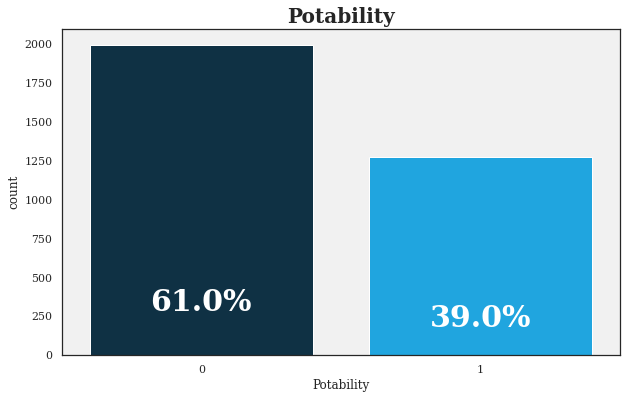

In [44]:
fig = plt.figure(figsize=(10,6))
ax=sns.countplot(data=df, x='Potability')
for i in ax.patches:
    ax.text(x=i.get_x()+i.get_width()/2, y=i.get_height()/7, s=f"{np.round(i.get_height()/len(df)*100,0)}%", ha='center', size=30, weight='bold', rotation=0, color='white')
plt.title("Potability", size=20, weight='bold')

In [30]:
# Splitting
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=18, stratify=y) #stratify=y

# Balancing data - oversampling minority
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

# Scaling
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [31]:
models = {"XGB Classifier": XGBClassifier(),
          "SVM Classifier": SVC(),}

def fit_and_score(models, X_train, X_test, y_train, y_test):  
    np.random.seed(18)
    model_scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,X_test,
                           y_test,scoring='accuracy',cv=5).mean()

    return model_scores

In [32]:
model_scores = fit_and_score(models,X_train,X_test,y_train,y_test)
model_scores

{'SVM Classifier': 0.6740535687565465, 'XGB Classifier': 0.775362860990573}

.

XGB Classifier

In [33]:
np.random.seed(18)

xgb_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ]}

rs_xgb = RandomizedSearchCV(XGBClassifier(),
                                param_distributions=xgb_grid,
                                cv=2,
                                n_iter=100,
                                verbose=0
                               )

rs_xgb.fit(X_train, y_train)
rs_xgb.best_params_

{'learning_rate': 0.25, 'max_depth': 10, 'min_child_weight': 1}

In [34]:
rs_xgb.score(X_test, y_test)

0.7777777777777778

.

##XGB - Confusion Matrix & Classification Report

In [35]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

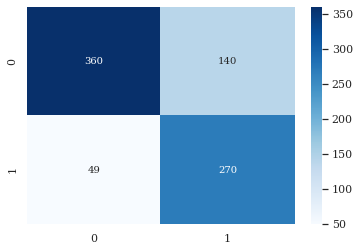

In [36]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       500
           1       0.66      0.85      0.74       319

    accuracy                           0.77       819
   macro avg       0.77      0.78      0.77       819
weighted avg       0.79      0.77      0.77       819



.

##SVM - Confusion Matrix & Classification Report

In [38]:
model_svm = SVC()
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)

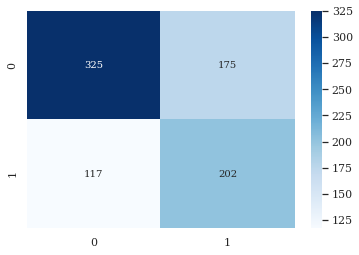

In [39]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69       500
           1       0.54      0.63      0.58       319

    accuracy                           0.64       819
   macro avg       0.64      0.64      0.64       819
weighted avg       0.66      0.64      0.65       819



.